In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from general_functions import create_balanced_dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
file = open("dataset/zone_7.pickle", "rb")
test_data = pickle.load(file)

In [4]:
#train_data_resampled = create_balanced_dataset(["dataset/zone_4.pickle"])

#with open("dataset/zone_4_resampled.pickle", "wb") as file:
#    pickle.dump(train_data_resampled, file)

with open("dataset/zone_4_resampled.pickle", "rb") as file:
    train_data_resampled = pickle.load(file)

In [5]:
X_train = np.array(train_data_resampled)[:, 1:].astype(np.float32)
X_train = StandardScaler().fit_transform(X_train).astype(np.float32)
y_train = np.array(train_data_resampled)[:, 0].astype(np.int64)

In [6]:
class EncoderDataset(Dataset):
    def __init__(self, X, y):
        self.data = X[:]
        self.labels = y[:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), self.labels[idx]

batch_size = 4096
dataloader = DataLoader(EncoderDataset(X_train, y_train), batch_size = batch_size, shuffle=True, drop_last=True)

In [7]:
class Net(nn.Module):
    def __init__(self, inputs):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(inputs, 64),
            
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),

            nn.ReLU(),
            nn.Linear(32, 2),
        )
        
    def forward(self, x):
        return self.net(x)
    
net = Net(81).to(device)

In [8]:
net

Net(
  (net): Sequential(
    (0): Linear(in_features=81, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [9]:
epoch_size = int(len(dataloader.dataset) / batch_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, cycle_momentum=False,
                                             step_size_up= epoch_size * 2, step_size_down=epoch_size * 1)

In [10]:
net.train()
losses = []
for epoch in range(200):
    running_loss = 0.0
    for i, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        #features = (features - features.mean()) / features.std()
        labels = labels.to(device)
        
        optimizer.zero_grad()

        preds = net(features)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        if i % epoch_size == epoch_size-1:    # print every 2000 mini-batches
            print('Epoch %d, loss: %.3f' %
                  (epoch + 1, running_loss / 299))
            losses.append(running_loss / 299)
            running_loss = 0.0

Epoch 1, loss: 0.115
Epoch 2, loss: 0.095
Epoch 3, loss: 0.091
Epoch 4, loss: 0.088
Epoch 5, loss: 0.088
Epoch 6, loss: 0.084
Epoch 7, loss: 0.081
Epoch 8, loss: 0.083
Epoch 9, loss: 0.081
Epoch 10, loss: 0.077
Epoch 11, loss: 0.080
Epoch 12, loss: 0.076
Epoch 13, loss: 0.072
Epoch 14, loss: 0.074
Epoch 15, loss: 0.072
Epoch 16, loss: 0.066
Epoch 17, loss: 0.070
Epoch 18, loss: 0.067
Epoch 19, loss: 0.061
Epoch 20, loss: 0.067
Epoch 21, loss: 0.063
Epoch 22, loss: 0.056
Epoch 23, loss: 0.062
Epoch 24, loss: 0.059
Epoch 25, loss: 0.052
Epoch 26, loss: 0.058
Epoch 27, loss: 0.055
Epoch 28, loss: 0.047
Epoch 29, loss: 0.054
Epoch 30, loss: 0.052


KeyboardInterrupt: 

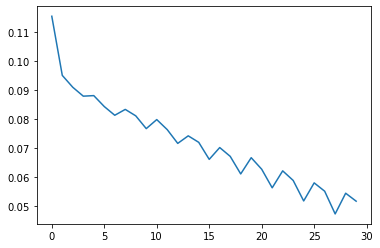

In [11]:
plt.plot([i for i in range(len(losses))], losses)

In [12]:
with torch.no_grad():
        acc = .0
        net.eval()
        for i, (features, labels) in enumerate(dataloader):
            features = features.to(device)
            #features = (features - features.mean()) / features.std()
            labels = labels.to(device)

            preds = net(features)
            preds = F.softmax(preds, dim=1)
            p = preds.argmax(dim=1)
            acc += (p==labels).sum().item() / preds.shape[0]
            
        print((acc/(i+1)))
net.train()
print()

0.9248046875



In [109]:
input.dtype

torch.float32

In [110]:
target.dtype

torch.float32